In [24]:
import matplotlib
from metpy.calc import pressure_to_height_std

In [2]:
%%capture
%run D:/codes/calculations.ipynb
%run D:/codes/calculations_kufstein_imst.ipynb
%run D:/codes/plots.ipynb

In [4]:
model = ['OBS','WRF','AROME','UM','ICON','ICON2TE']
only_model = ['WRF','AROME','UM','ICON','ICON2TE']

### Height z & Pressure p

In [5]:
z_surf = np.array([obs_z_surf, wrf_acinn_z_surf, arome_z_surf, ukmo_z_surf, icon_z_surf, icon2TE_z_surf])
z_max = np.array([obs_z_of_T_max, wrf_acinn_z_of_T_max, arome_z_of_T_max, ukmo_z_of_T_max, icon_z_of_T_max, icon2TE_z_of_T_max]).T.flatten()
z_seg = np.ones(6) * height_seegrube
p_surf = np.array([obs_p_surf, wrf_acinn_p_surf, arome_p_surf, ukmo_p_surf, icon_p_surf, icon2TE_p_surf])
p_max = np.array([obs_p_of_T_max, wrf_acinn_p_of_T_max, arome_p_of_T_max, ukmo_p_of_T_max, icon_p_of_T_max, icon2TE_p_of_T_max]).T.flatten()

### Temperature T

In [6]:
T_surf = np.array([obs_T_surf, wrf_acinn_T_surf, arome_T_surf, ukmo_T_surf, icon_T_surf, icon2TE_T_surf]).T.flatten()
T_max = np.array([obs_T_max, wrf_acinn_T_max, arome_T_max, ukmo_T_max, icon_T_max, icon2TE_T_max])
T_seg = np.array([obs_T_seg, wrf_acinn_T_seg, arome_T_seg, ukmo_T_seg, icon_T_seg, icon2TE_T_seg]).T.flatten()

### Potential Temperature $\theta$

In [7]:
th_surf = np.array([obs_th_surf, wrf_acinn_th_surf, arome_th_surf, ukmo_th_surf, icon_th_surf, icon2TE_th_surf]).flatten()
th_max = np.array([obs_th_max, wrf_acinn_th_max, arome_th_max, ukmo_th_max, icon_th_max, icon2TE_th_max]).flatten()
th_seg = np.array([obs_th_seg, wrf_acinn_th_seg, arome_th_seg, ukmo_th_seg, icon_th_seg, icon2TE_th_seg]).flatten()

### Brunt-Väisälä Frequency N

In [8]:
bv_seg = bv_freq(th_surf, th_seg, z_surf, z_seg)
bv_max = bv_freq(th_surf, th_max, z_surf, z_max)

### Bulk Temperature Gradient

In [9]:
bulk_seg = (T_seg - T_surf) / (z_seg - z_surf)
bulk_max = (T_max - T_surf) / (z_max - z_surf)

### Valley Heat Deficit H

In [10]:
# bulk valley heat deficit between Seegrube and Surface (Temperature in °C, not pot.T!, height in z)
H_seg = valley_heat_def(T_surf, T_seg, z_surf, z_seg).magnitude
# bulk valley heat deficit between Seegrube and Surface (Temperature in °C, not pot.T!, height in z)
H_max = valley_heat_def(T_surf, T_max, z_surf, z_max).magnitude

### Absolute Temperature Differences

In [11]:
delta_T_seg = T_seg - T_surf
delta_T_max = T_max - T_surf
delta_th_seg = (th_seg - th_surf).T.flatten()
delta_th_max = (th_max - th_surf).T.flatten()

# Principal Component Analysis PCA

### IBK

In [17]:
bv_max = np.zeros(6)
bv_seg = np.zeros(6)
for i in range(6):
    bv_max[i] = bv_freq(th_surf[i], th_max[i], z_surf[i], z_max[i])
    bv_seg[i] = bv_freq(th_surf[i], th_seg[i], z_surf[i], z_seg[i])
    
    
bulk_max = (T_max - T_surf) / (z_max - z_surf)
bulk_seg = (T_seg - T_surf) / (z_seg - z_surf)


H_max = valley_heat_def(T_surf, T_max, z_surf, z_max).magnitude
H_seg = valley_heat_def(T_surf, T_seg, z_surf, z_seg).magnitude


delta_T_max = T_max - T_surf
delta_th_max = (th_max - th_surf).T.flatten()
delta_T_seg = T_seg - T_surf
delta_th_seg = (th_seg - th_surf).T.flatten()

In [18]:
def data_max_ibk(m):
    for i in range(6):
        if m == model[i]:
            m = i

    ar = np.array([T_max[m], th_max[m], bv_max[m], bulk_max[m],
                   H_max[m], delta_T_max[m], delta_th_max[m]])
    return ar

In [19]:
def data_seg_ibk(m):
    for i in range(6):
        if m == model[i]:
            m = i

    ar = np.array([T_seg[m], th_seg[m], bv_seg[m], bulk_seg[m],
                   H_seg[m], delta_T_seg[m], delta_th_seg[m]])
    return ar

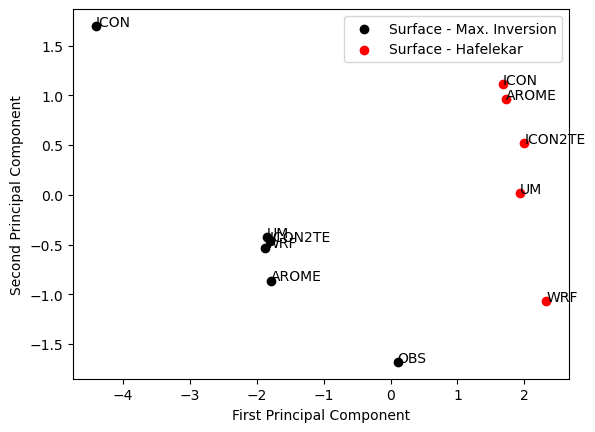

In [25]:
data_ibk1 = np.array([data_max_ibk(model[i]) for i in range(6)])
data_ibk2 = np.array([data_seg_ibk(model[i]) for i in range(6)])

data = np.concatenate((data_ibk1, data_ibk2))
mean = np.mean(data, 0)
std = np.std(data, 0)
data_norm = (data - mean) / std
#print(data.shape)

cov = np.cov(data_norm.T)
#print(cov.shape)
eival, eivec = np.linalg.eigh(cov)
#print(eival.shape)
#print(eivec.shape)
eival = np.flip(eival)
eivec = np.flip(eivec, 1)

data_proj = np.matmul(data_norm, eivec)

ind_dim = [0, 1, 2]

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(data_proj[:6, ind_dim[0]], data_proj[:6, ind_dim[2]], color = ['k'], label=label[0])
ax.scatter(data_proj[6:11, ind_dim[0]], data_proj[6:11, ind_dim[2]], color = ['r'], label=label[-1])

for i, name in enumerate(model):
    ax.annotate(name, (data_proj[i, ind_dim[0]], data_proj[i, ind_dim[2]]))
for i, name in enumerate(only_model):
    ax.annotate(name, (data_proj[i+6, ind_dim[0]], data_proj[i+6, ind_dim[2]]))
    

ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.legend();

# KUF

Parameters

In [26]:
bv_max_k = np.zeros(5)
bv_seg_k = np.zeros(5)
for i in range(5):
    bv_max_k[i] = bv_freq(th_surf_k[i], th_max_k[i], k_z_surf[i], k_z_max[i])
    bv_seg_k[i] = bv_freq(th_surf_k[i], th_seg_k[i], k_z_surf[i], z_seg[i])
    
    
bulk_max_k = (T_max_k - T_surf_k) / (k_z_max - k_z_surf)
bulk_seg_k = (T_seg_k - T_surf_k) / (z_seg[0] - k_z_surf)


H_max_k = valley_heat_def(T_surf_k, T_max_k, k_z_surf, k_z_max).magnitude
H_seg_k = valley_heat_def(T_surf_k, T_seg_k, k_z_surf, z_seg[0]).magnitude


delta_T_max_k = T_max_k - T_surf_k
delta_th_max_k = (th_max_k - th_surf_k).T.flatten()
delta_T_seg_k = T_seg_k - T_surf_k
delta_th_seg_k = (th_seg_k - th_surf_k).T.flatten()



In [27]:
def data_max_kuf(m):
    for i in range(5):
        if m == only_model[i]:
            m = i

    ar = np.array([T_max_k[m], th_max_k[m], bv_max_k[m], bulk_max_k[m],
                   H_max_k[m], delta_T_max_k[m], delta_th_max_k[m]])
    return ar
#data_max_kuf('WRF')

In [28]:
def data_seg_kuf(m):
    for i in range(5):
        if m == only_model[i]:
            m = i

    ar = np.array([T_seg_k[m], th_seg_k[m], bv_seg_k[m], bulk_seg_k[m],
                   H_seg_k[m], delta_T_seg_k[m], delta_th_seg_k[m]])
    return ar
#data_seg_kuf('WRF')

In [29]:
label=["Surface - Max. Inversion", "_f","_f", "_f","_f","_f","_f","_f","_f","Surface - Hafelekar"]
len(label)

10

(10, 7)
(7, 7)
(7,)


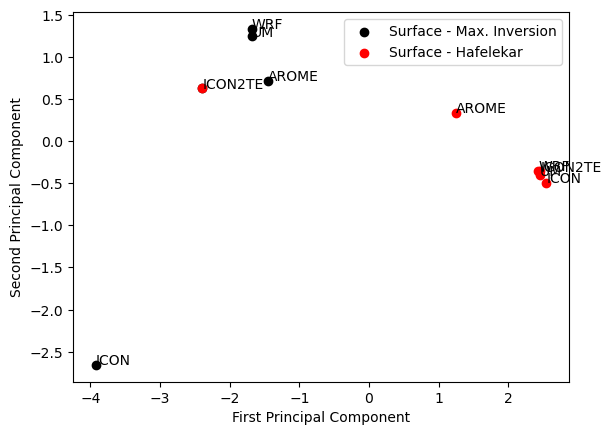

In [30]:
data_kuf1 = np.array([data_max_kuf(only_model[i]) for i in range(5)])
data_kuf2 = np.array([data_seg_kuf(only_model[i]) for i in range(5)])

data = np.concatenate((data_kuf1, data_kuf2))
mean = np.mean(data, 0)
std = np.std(data, 0)
data_norm = (data - mean) / std
print(data.shape)

cov = np.cov(data_norm.T)
print(cov.shape)
eival, eivec = np.linalg.eigh(cov)
print(eival.shape)
#print(eivec.shape)
eival = np.flip(eival)
eivec = np.flip(eivec, 1)

data_proj = np.matmul(data_norm, eivec)

ind_dim = [0, 1, 2]

fig = plt.figure()
ax = fig.add_subplot()
#for i in range(len(label)):
ax.scatter(data_proj[:5, ind_dim[0]], data_proj[:5, ind_dim[1]],  
           color = ['k'],
           label=label[0])
ax.scatter(data_proj[4:, ind_dim[0]], data_proj[4:, ind_dim[1]],  
           color = ['r'],
           label=label[-1])

for i, name in enumerate(only_model):
    ax.annotate(name, (data_proj[i, ind_dim[0]], data_proj[i, ind_dim[1]]))
    ax.annotate(name, (data_proj[i+5, ind_dim[0]], data_proj[i+5, ind_dim[1]]))
    

ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.legend();

# Imst

Parameters

In [31]:
bv_max_i = np.zeros(5)
bv_seg_i = np.zeros(5)
for i in range(5):
    bv_max_i[i] = bv_freq(th_surf_i[i], th_max_i[i], i_z_surf[i], i_z_max[i])
    bv_seg_i[i] = bv_freq(th_surf_i[i], th_seg_i[i], i_z_surf[i], z_seg[i])
    
    
bulk_max_i = (T_max_i - T_surf_i) / (i_z_max - i_z_surf)
bulk_seg_i = (T_seg_i - T_surf_i) / (z_seg[0] - i_z_surf)


H_max_i = valley_heat_def(T_surf_i, T_max_i, i_z_surf, i_z_max).magnitude
H_seg_i = valley_heat_def(T_surf_i, T_seg_i, i_z_surf, z_seg[0]).magnitude


delta_T_max_i = T_max_i - T_surf_i
delta_th_max_i = (th_max_i - th_surf_i).T.flatten()
delta_T_seg_i = T_seg_i - T_surf_i
delta_th_seg_i = (th_seg_i - th_surf_i).T.flatten()
 


In [32]:
def data_max_imst(m):
    for i in range(5):
        if m == only_model[i]:
            m = i

    ar = np.array([T_max_i[m], th_max_i[m], bv_max_i[m], bulk_max_i[m],
                   H_max_i[m], delta_T_max_i[m], delta_th_max_i[m]])
    return ar
#data_max_kuf('WRF')

In [33]:
def data_seg_imst(m):
    for i in range(5):
        if m == only_model[i]:
            m = i

    ar = np.array([T_seg_i[m], th_seg_i[m], bv_seg_i[m], bulk_seg_i[m],
                   H_seg_i[m], delta_T_seg_i[m], delta_th_seg_i[m]])
    return ar
#data_seg_kuf('WRF')

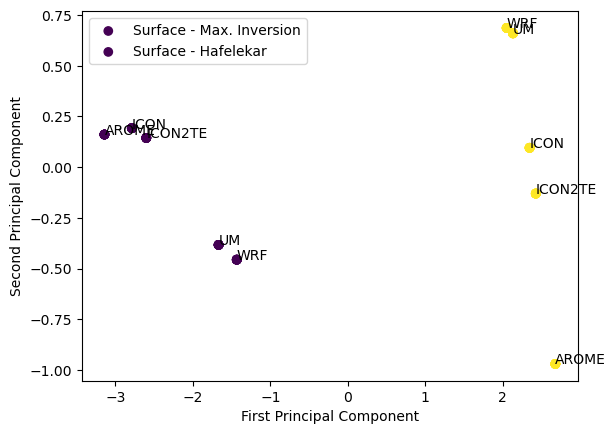

In [34]:
data_imst1 = np.array([data_max_imst(only_model[i]) for i in range(5)])
data_imst2 = np.array([data_seg_imst(only_model[i]) for i in range(5)])

data = np.concatenate((data_imst1, data_imst2))
mean = np.mean(data, 0)
std = np.std(data, 0)
data_norm = (data - mean) / std
#print(data.shape)

cov = np.cov(data_norm.T)
#print(cov.shape)
eival, eivec = np.linalg.eigh(cov)
#print(eival.shape)
#print(eivec.shape)
eival = np.flip(eival)
eivec = np.flip(eivec, 1)

data_proj = np.matmul(data_norm, eivec)

ind_dim = [0, 1, 2]

fig = plt.figure()
ax = fig.add_subplot()
for i in range(len(label)):
    ax.scatter(data_proj[:, ind_dim[0]], data_proj[:, ind_dim[2]], c=[0, 0, 0, 0, 0, 1, 1, 1, 1, 1], 
               label=label[i])

for i, name in enumerate(only_model):
    ax.annotate(name, (data_proj[i, ind_dim[0]], data_proj[i, ind_dim[2]]))
for i, name in enumerate(only_model):
    ax.annotate(name, (data_proj[i+5, ind_dim[0]], data_proj[i+5, ind_dim[2]]))
    

ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.legend();

# ALLES


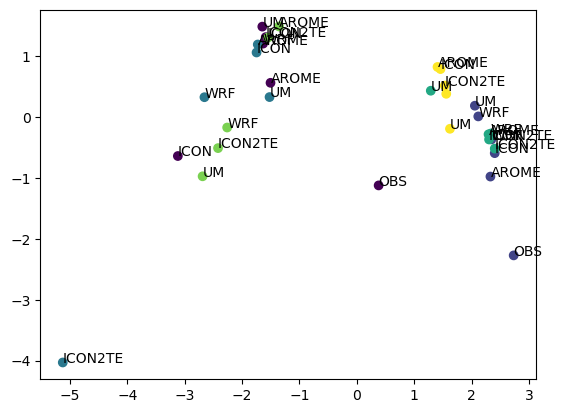

In [35]:
data = np.concatenate((data_ibk1, data_ibk2, data_kuf1, data_kuf2, data_imst1, data_imst2))
# print(data.shape)
mean = np.mean(data, 0)
std = np.std(data, 0)
data_norm = (data - mean) / std
# print(data.shape)

cov = np.cov(data_norm.T)
# print(cov.shape)
eival, eivec = np.linalg.eigh(cov)
# print(eival.shape)
# print(eivec.shape)
eival = np.flip(eival)
eivec = np.flip(eivec, 1)

data_proj = np.matmul(data_norm, eivec)

ind_dim = [0, 1, 2]

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(data_proj[:, ind_dim[0]], data_proj[:, ind_dim[1]], c=[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
                                                                  2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
                                                                 4, 4, 4, 4, 4, 5, 5, 5, 5, 5])

for i, name in enumerate(model):
    ax.annotate(name, (data_proj[i, ind_dim[0]], data_proj[i, ind_dim[1]]))
for i, name in enumerate(model):
    ax.annotate(name, (data_proj[i+6, ind_dim[0]], data_proj[i+6, ind_dim[1]]))
for i, name in enumerate(only_model):
    ax.annotate(name, (data_proj[i+11, ind_dim[0]], data_proj[i+11, ind_dim[1]]))
for i, name in enumerate(only_model):
    ax.annotate(name, (data_proj[i+16, ind_dim[0]], data_proj[i+16, ind_dim[1]]))
for i, name in enumerate(only_model):
    ax.annotate(name, (data_proj[i+21, ind_dim[0]], data_proj[i+21, ind_dim[1]]))
for i, name in enumerate(only_model):
    ax.annotate(name, (data_proj[i+26, ind_dim[0]], data_proj[i+26, ind_dim[1]]))

In [36]:
labels = ['Innsbruck', "_f", "_f","_f","_f","_f",
        'Kufstein',"_f","_f","_f","_f",
        'Imst', "_f","_f","_f","_f",]

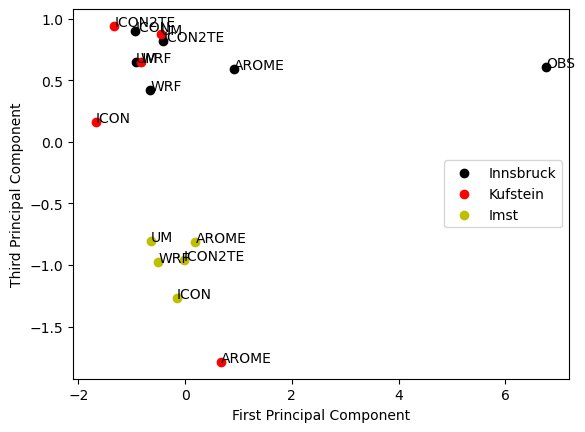

In [40]:
# SURF - MAX for IBK, KUF, IMST

# Prepare the data
data = np.concatenate((data_ibk1, data_kuf1, data_imst1))
mean = np.mean(data, 0)
std = np.std(data, 0)
data_norm = (data - mean) / std
# print(data.shape)

# Covariance Matrix, Eigenvalues, Eigenvectors
cov = np.cov(data_norm.T)
eival, eivec = np.linalg.eigh(cov)
# print(eival.shape)
# print(eivec.shape)
eival = np.flip(eival)
eivec = np.flip(eivec, 1)

data_proj = np.matmul(data_norm, eivec)

ind_dim = [0, 1, 2, 3]

# Plot
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(data_proj[:6, ind_dim[0]], data_proj[:6, ind_dim[2]], 
           color = 'k', label=labels[0])
ax.scatter(data_proj[6:11, ind_dim[0]], data_proj[6:11, ind_dim[2]], 
           color = 'r', label=labels[6])
ax.scatter(data_proj[11:, ind_dim[0]], data_proj[11:, ind_dim[2]], 
           color = 'y', label=labels[11])

# Label the dots
for i, name in enumerate(model):
    ax.annotate(name, (data_proj[i, ind_dim[0]], 
                       data_proj[i, ind_dim[2]]))
for i, name in enumerate(only_model):
    ax.annotate(name, (data_proj[i+6, ind_dim[0]], 
                       data_proj[i+6, ind_dim[2]]))
for i, name in enumerate(only_model):
    ax.annotate(name, (data_proj[i+11, ind_dim[0]], data_proj[i+11, ind_dim[2]]))
    
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Third Principal Component')
ax.legend(loc=7);
plt.savefig(f"{dir_PLOTS}/PCA/PCA_all_max.svg")

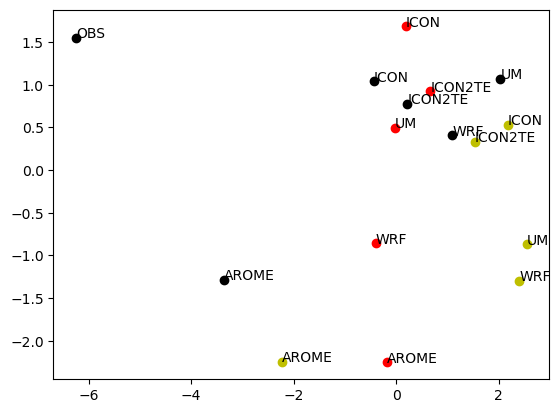

In [44]:
#SURF - SEG
data = np.concatenate((data_ibk2, data_kuf2, data_imst2))
# print(data.shape)
mean = np.mean(data, 0)
std = np.std(data, 0)
data_norm = (data - mean) / std
# print(data.shape)

cov = np.cov(data_norm.T)
# print(cov.shape)
eival, eivec = np.linalg.eigh(cov)
# print(eival.shape)
# print(eivec.shape)
eival = np.flip(eival)
eivec = np.flip(eivec, 1)

data_proj = np.matmul(data_norm, eivec)

ind_dim = [0, 1, 2]

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(data_proj[:6, ind_dim[0]], data_proj[:6, ind_dim[1]], color = ['k'], label=labels[0])
ax.scatter(data_proj[6:11, ind_dim[0]], data_proj[6:11, ind_dim[1]], color = ['r'], label=labels[6])
ax.scatter(data_proj[11:, ind_dim[0]], data_proj[11:, ind_dim[1]], color = ['y'], label=labels[11])

for i, name in enumerate(model):
    ax.annotate(name, (data_proj[i, ind_dim[0]], data_proj[i, ind_dim[1]]))
for i, name in enumerate(only_model):
    ax.annotate(name, (data_proj[i+6, ind_dim[0]], data_proj[i+6, ind_dim[1]]))
for i, name in enumerate(only_model):
    ax.annotate(name, (data_proj[i+11, ind_dim[0]], data_proj[i+11, ind_dim[1]]))